In [2]:
import dask
import dask_awkward as dak
from coffea.dataset_tools import preprocess
from distributed import Client
from matplotlib import pyplot as plt

import egamma_tnp
from egamma_tnp.plot import plot_efficiency
from egamma_tnp.triggers import ElectronTagNProbeFromNTuples

In [3]:
ele30_filters = [
    "hltEG30L1SingleEGOrEtFilter",
    "hltEle30WPTightClusterShapeFilter",
    "hltEle30WPTightHEFilter",
    "hltEle30WPTightEcalIsoFilter",
    "hltEle30WPTightHcalIsoFilter",
    "hltEle30WPTightPixelMatchFilter",
    "hltEle30WPTightPMS2Filter",
    "hltEle30WPTightGsfOneOEMinusOneOPFilter",
    "hltEle30WPTightGsfMissingHitsFilter",
    "hltEle30WPTightGsfDetaFilter",
    "hltEle30WPTightGsfDphiFilter",
    "hltEle30WPTightGsfTrackIsoFilter",
]

In [4]:
client = Client()

In [6]:
fileset = {
    "data_EGamma_Run2024F": {
        "files": {
            "tnptuples/data_EGamma0_Run2024F.root": "tnpEleTrig/fitter_tree",
            "tnptuples/data_EGamma1_Run2024F.root": "tnpEleTrig/fitter_tree",
        },
    },
}

fileset_available, fileset_updated = preprocess(fileset, step_size=500_000, skip_bad_files=True)

In [7]:
def run_filter(events, when, run):
    if when == "before":
        return events[events.run < run]
    elif when == "after":
        return events[(events.run > run) & (events.run < 383129)]
    else:
        raise ValueError("`when` should be either 'before' or 'after'")

In [11]:
egamma_tnp.binning.set(
    "el_pt_bins",
    [
        5,
        10,
        12,
        14,
        16,
        18,
        20,
        23,
        26,
        28,
        30,
        32,
        34,
        36,
        38,
        40,
        45,
        50,
        60,
        80,
        100,
        150,
        250,
        400,
    ],
)

to_compute = {}
for filter in ele30_filters:
    to_compute[filter] = {}
    tnp = ElectronTagNProbeFromNTuples(
        fileset_available,
        [f"pass{filter.replace('hlt', 'HLT')}"],
        cutbased_id="passingCutBasedTight122XV1",
        goldenjson="json/steam_august_2024.json",
        extra_filter=run_filter,
        extra_filter_args={"when": "before", "run": 382799},
    )
    to_compute[filter]["before FPix"] = tnp.get_1d_pt_eta_phi_tnp_histograms(
        f"pass{filter.replace('hlt', 'HLT')}",
        eta_regions_pt={
            "barrel": [0.0, 1.4442],
            "endcap_loweta": [1.566, 2.0],
            "endcap_higheta": [2.0, 2.5],
        },
        plateau_cut=35,
        uproot_options={"allow_read_errors_with_report": True},
    )
    tnp = ElectronTagNProbeFromNTuples(
        fileset_available,
        [f"pass{filter.replace('hlt', 'HLT')}"],
        cutbased_id="passingCutBasedTight122XV1",
        goldenjson="json/steam_august_2024.json",
        extra_filter=run_filter,
        extra_filter_args={"when": "after", "run": 382799},
    )
    to_compute[filter]["after FPix"] = tnp.get_1d_pt_eta_phi_tnp_histograms(
        f"pass{filter.replace('hlt', 'HLT')}",
        eta_regions_pt={
            "barrel": [0.0, 1.4442],
            "endcap_loweta": [1.566, 2.0],
            "endcap_higheta": [2.0, 2.5],
        },
        plateau_cut=35,
        uproot_options={"allow_read_errors_with_report": True},
    )

dak.necessary_columns(to_compute)

{'from-uproot-63f77021f8725744df1b53bd48e1e75b': frozenset({'el_eta',
            'el_phi',
            'el_pt',
            'el_q',
            'lumi',
            'pair_mass',
            'passHLTEG30L1SingleEGOrEtFilter',
            'passHLTEle30WPTightClusterShapeFilter',
            'passHLTEle30WPTightEcalIsoFilter',
            'passHLTEle30WPTightGsfDetaFilter',
            'passHLTEle30WPTightGsfDphiFilter',
            'passHLTEle30WPTightGsfMissingHitsFilter',
            'passHLTEle30WPTightGsfOneOEMinusOneOPFilter',
            'passHLTEle30WPTightGsfTrackIsoFilter',
            'passHLTEle30WPTightHEFilter',
            'passHLTEle30WPTightHcalIsoFilter',
            'passHLTEle30WPTightPMS2Filter',
            'passHLTEle30WPTightPixelMatchFilter',
            'passingCutBasedTight122XV1',
            'run',
            'tag_Ele_eta',
            'tag_Ele_pt',
            'tag_Ele_q'})}

In [12]:
%%time

out = dask.compute(to_compute)[0]

CPU times: user 33.9 s, sys: 1.09 s, total: 35 s
Wall time: 38.5 s


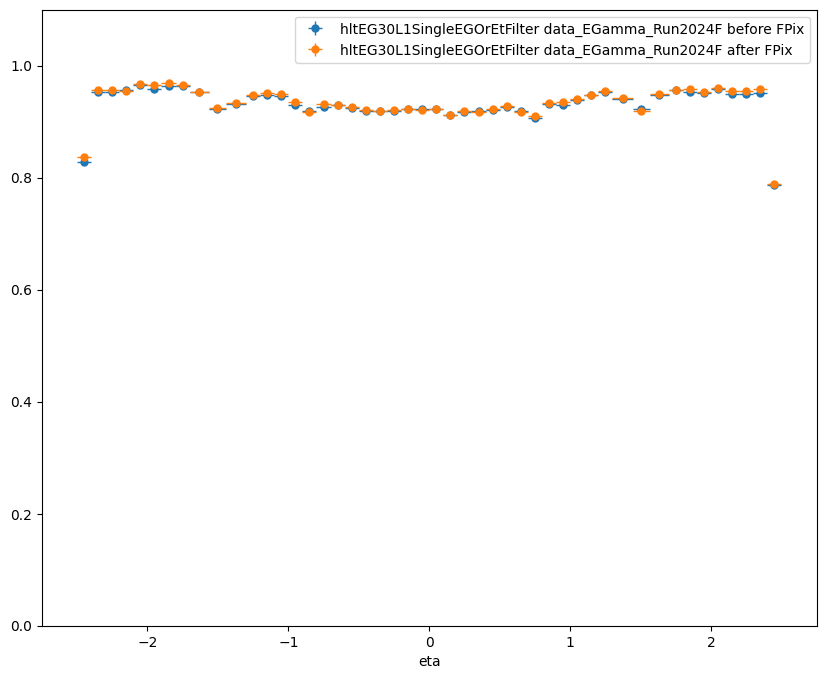

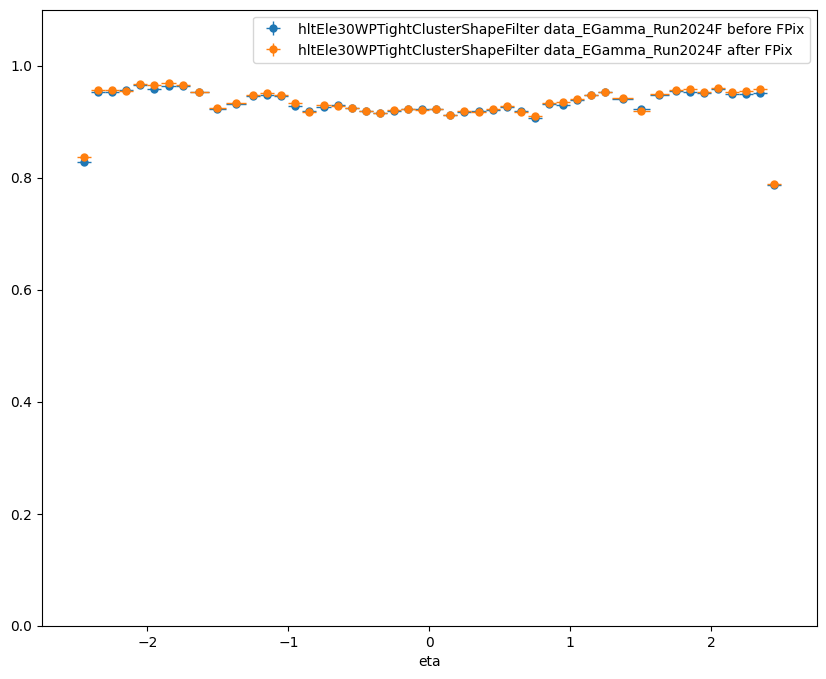

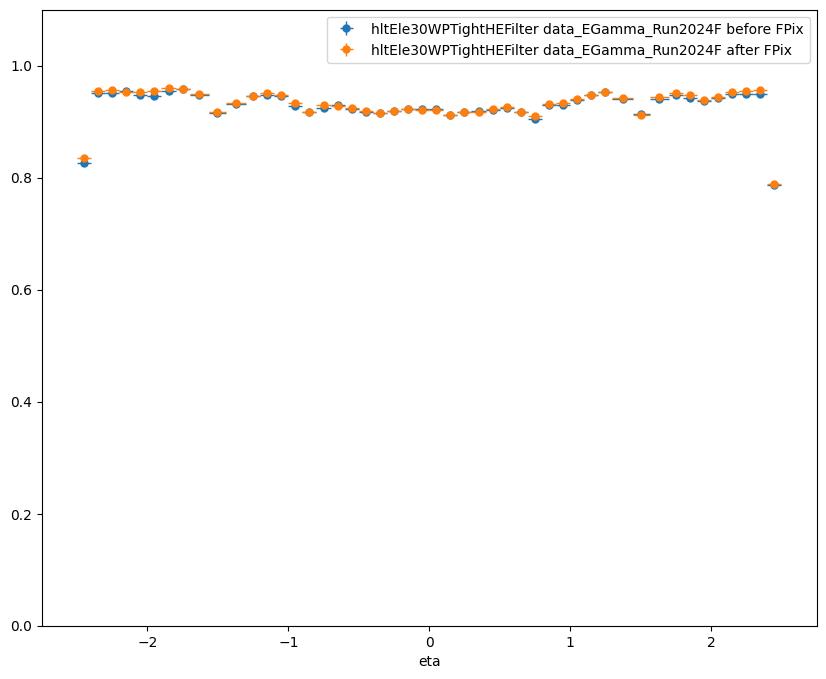

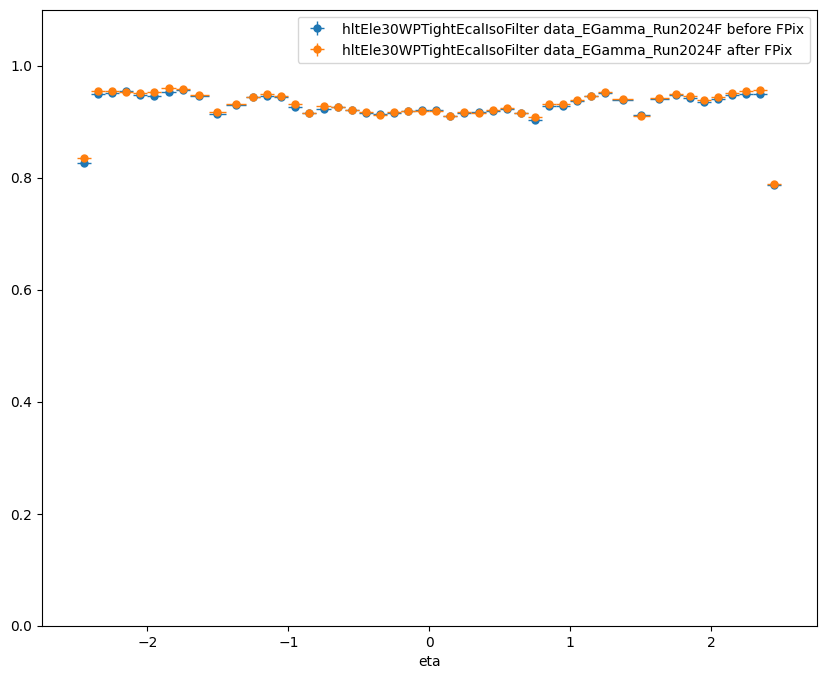

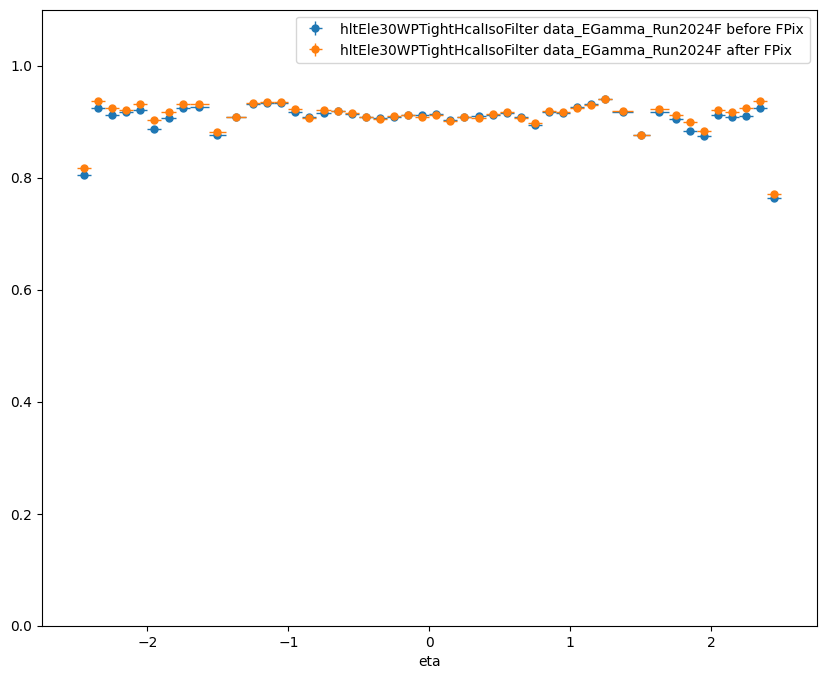

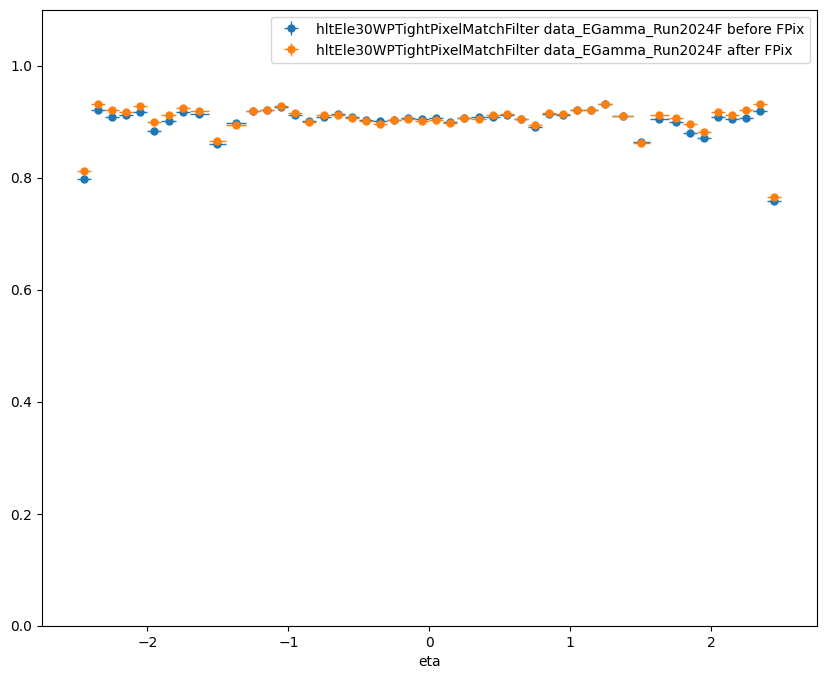

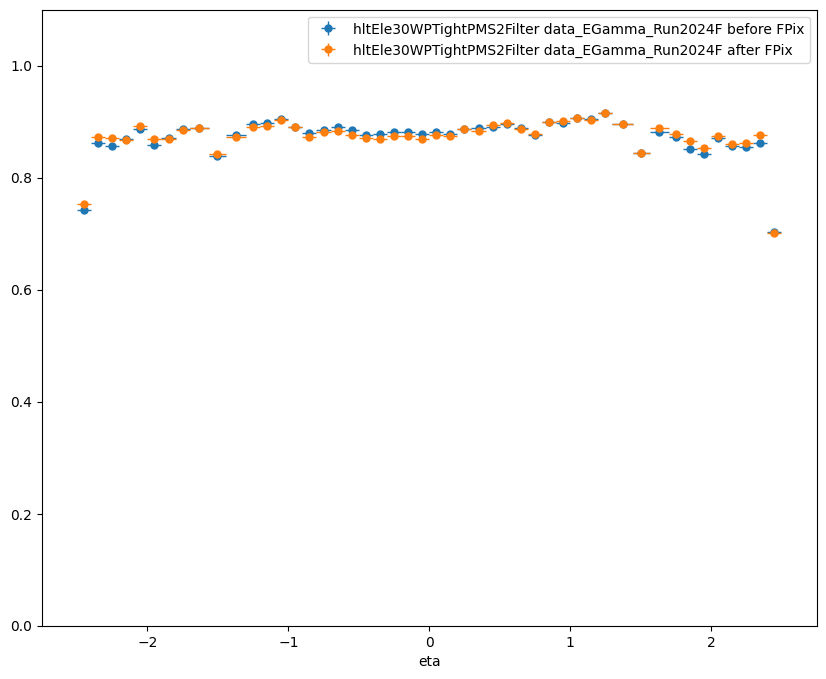

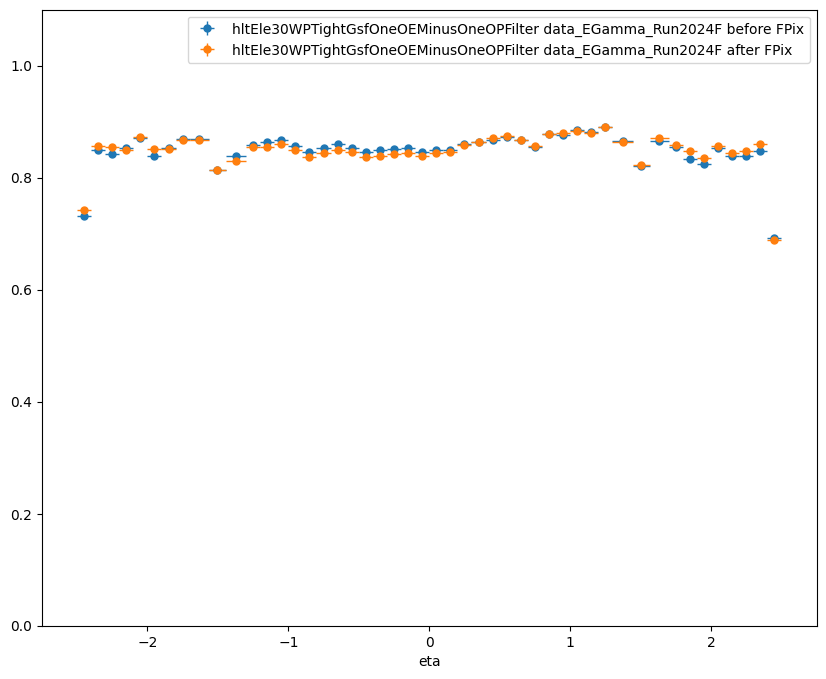

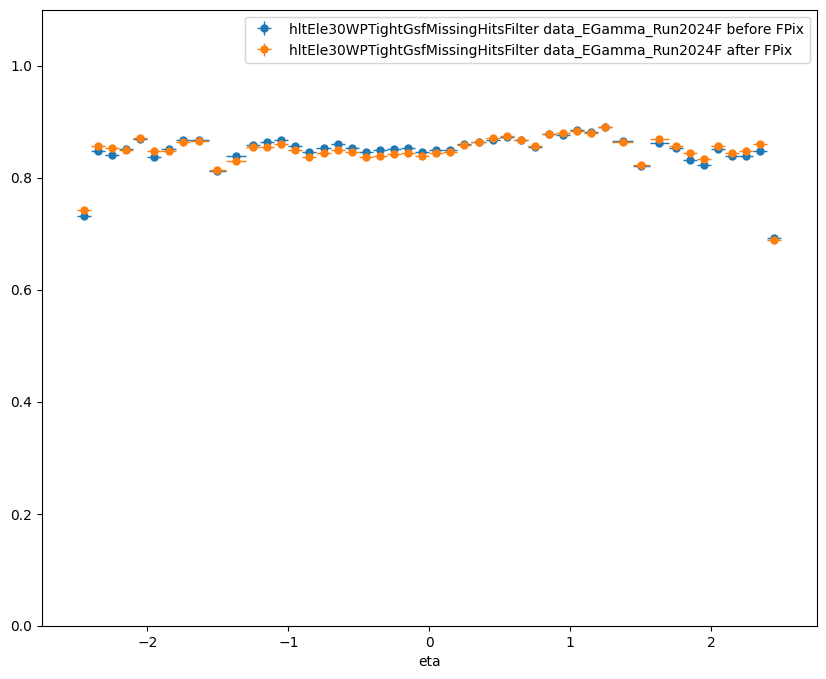

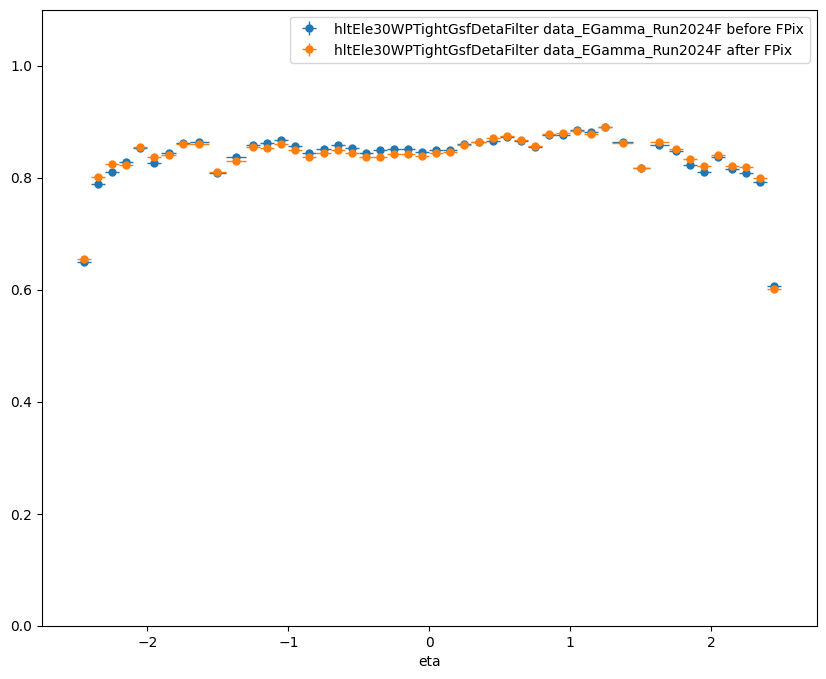

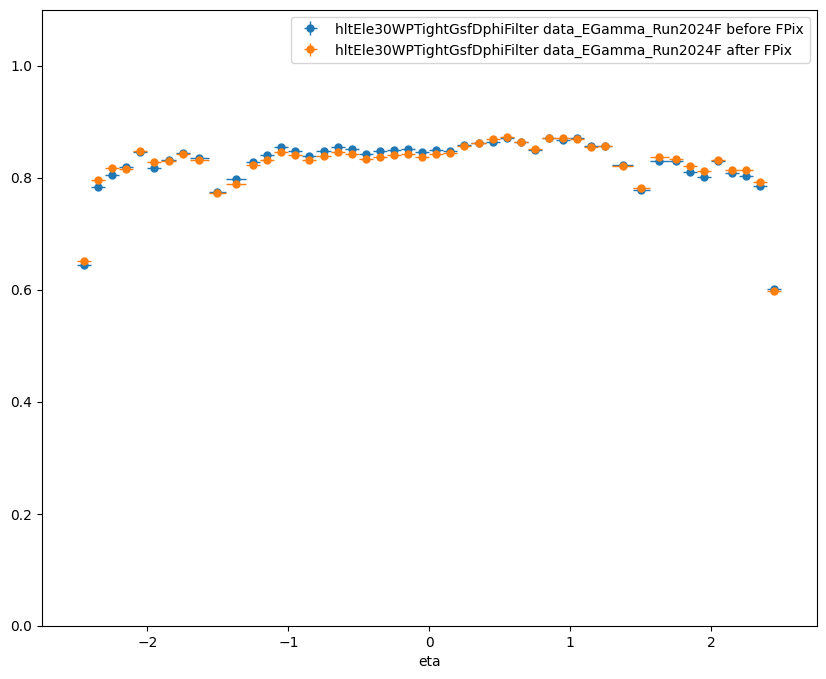

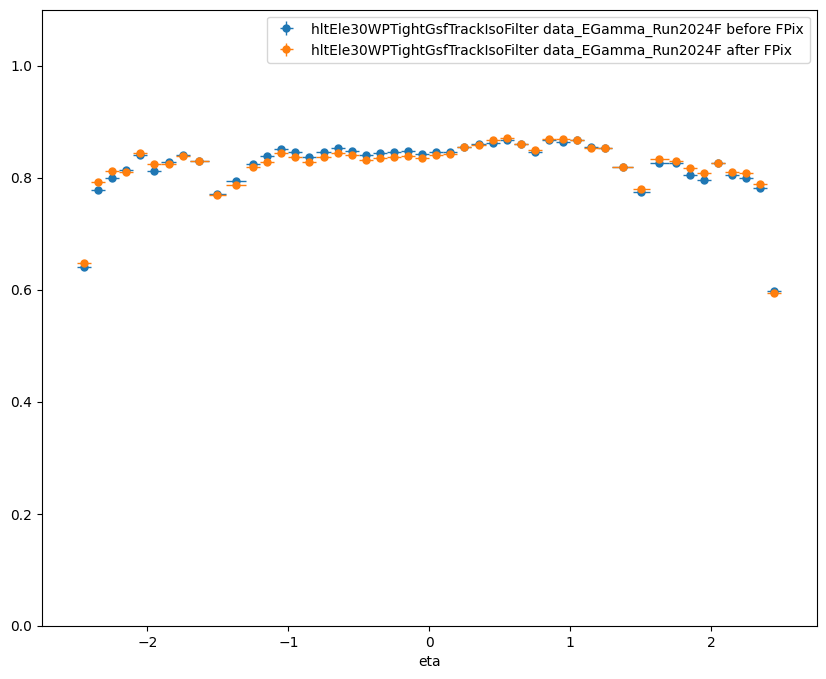

In [13]:
for filter in ele30_filters:
    # plt.figure(figsize=(10, 8))
    # for pu_region, other in out[filter].items():
    #     all_hists = other[0]
    #     for dataset, hists in all_hists.items():
    #         plot_efficiency(
    #             hists["pt"]["barrel"]["passing"],
    #             hists["pt"]["barrel"]["failing"],
    #             label=f"{filter} {dataset} barrel {pu_region}",
    #         )
    # plt.ylim(0, 1.1)
    # plt.xscale("log")
    # plt.legend()
    # plt.show()

    # plt.figure(figsize=(10, 8))
    # for pu_region, other in out[filter].items():
    #     all_hists = other[0]
    #     for dataset, hists in all_hists.items():
    #         plot_efficiency(
    #             hists["pt"]["endcap_loweta"]["passing"],
    #             hists["pt"]["endcap_loweta"]["failing"],
    #             label=f"{filter} {dataset} endcap loweta {pu_region}",
    #         )
    # plt.ylim(0, 1.1)
    # plt.xscale("log")
    # plt.legend()
    # plt.show()

    # plt.figure(figsize=(10, 8))
    # for pu_region, other in out[filter].items():
    #     all_hists = other[0]
    #     for dataset, hists in all_hists.items():
    #         plot_efficiency(
    #             hists["pt"]["endcap_higheta"]["passing"],
    #             hists["pt"]["endcap_higheta"]["failing"],
    #             label=f"{filter} {dataset} endcap higheta {pu_region}",
    #         )
    # plt.ylim(0, 1.1)
    # plt.xscale("log")
    # plt.legend()
    # plt.show()

    plt.figure(figsize=(10, 8))
    for pu_region, other in out[filter].items():
        all_hists = other[0]
        for dataset, hists in all_hists.items():
            plot_efficiency(
                hists["eta"]["entire"]["passing"],
                hists["eta"]["entire"]["failing"],
                label=f"{filter} {dataset} {pu_region}",
            )
    plt.ylim(0, 1.1)
    plt.legend()
    plt.show()

    # plt.figure(figsize=(10, 8))
    # for pu_region, other in out[filter].items():
    #     all_hists = other[0]
    #     for dataset, hists in all_hists.items():
    #         plot_efficiency(
    #             hists["phi"]["entire"]["passing"],
    #             hists["phi"]["entire"]["failing"],
    #             label=f"{filter} {dataset} {pu_region}",
    #         )
    # plt.ylim(0, 1.1)
    # plt.legend()
    # plt.show()